# Budget Allocation

# Import Necessary libraries

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Loading a Pre-Trained Model

In [3]:
name = 'budget_optimizer_model.nc'
mmm = DelayedSaturatedMMM.load(name)

# Problem Statement
Before jump into the data, We already created a model in MediaMixModeling.py and so the problem goes on. Now, we're on the last step how to we distribute our ROI and how can we decide it ?

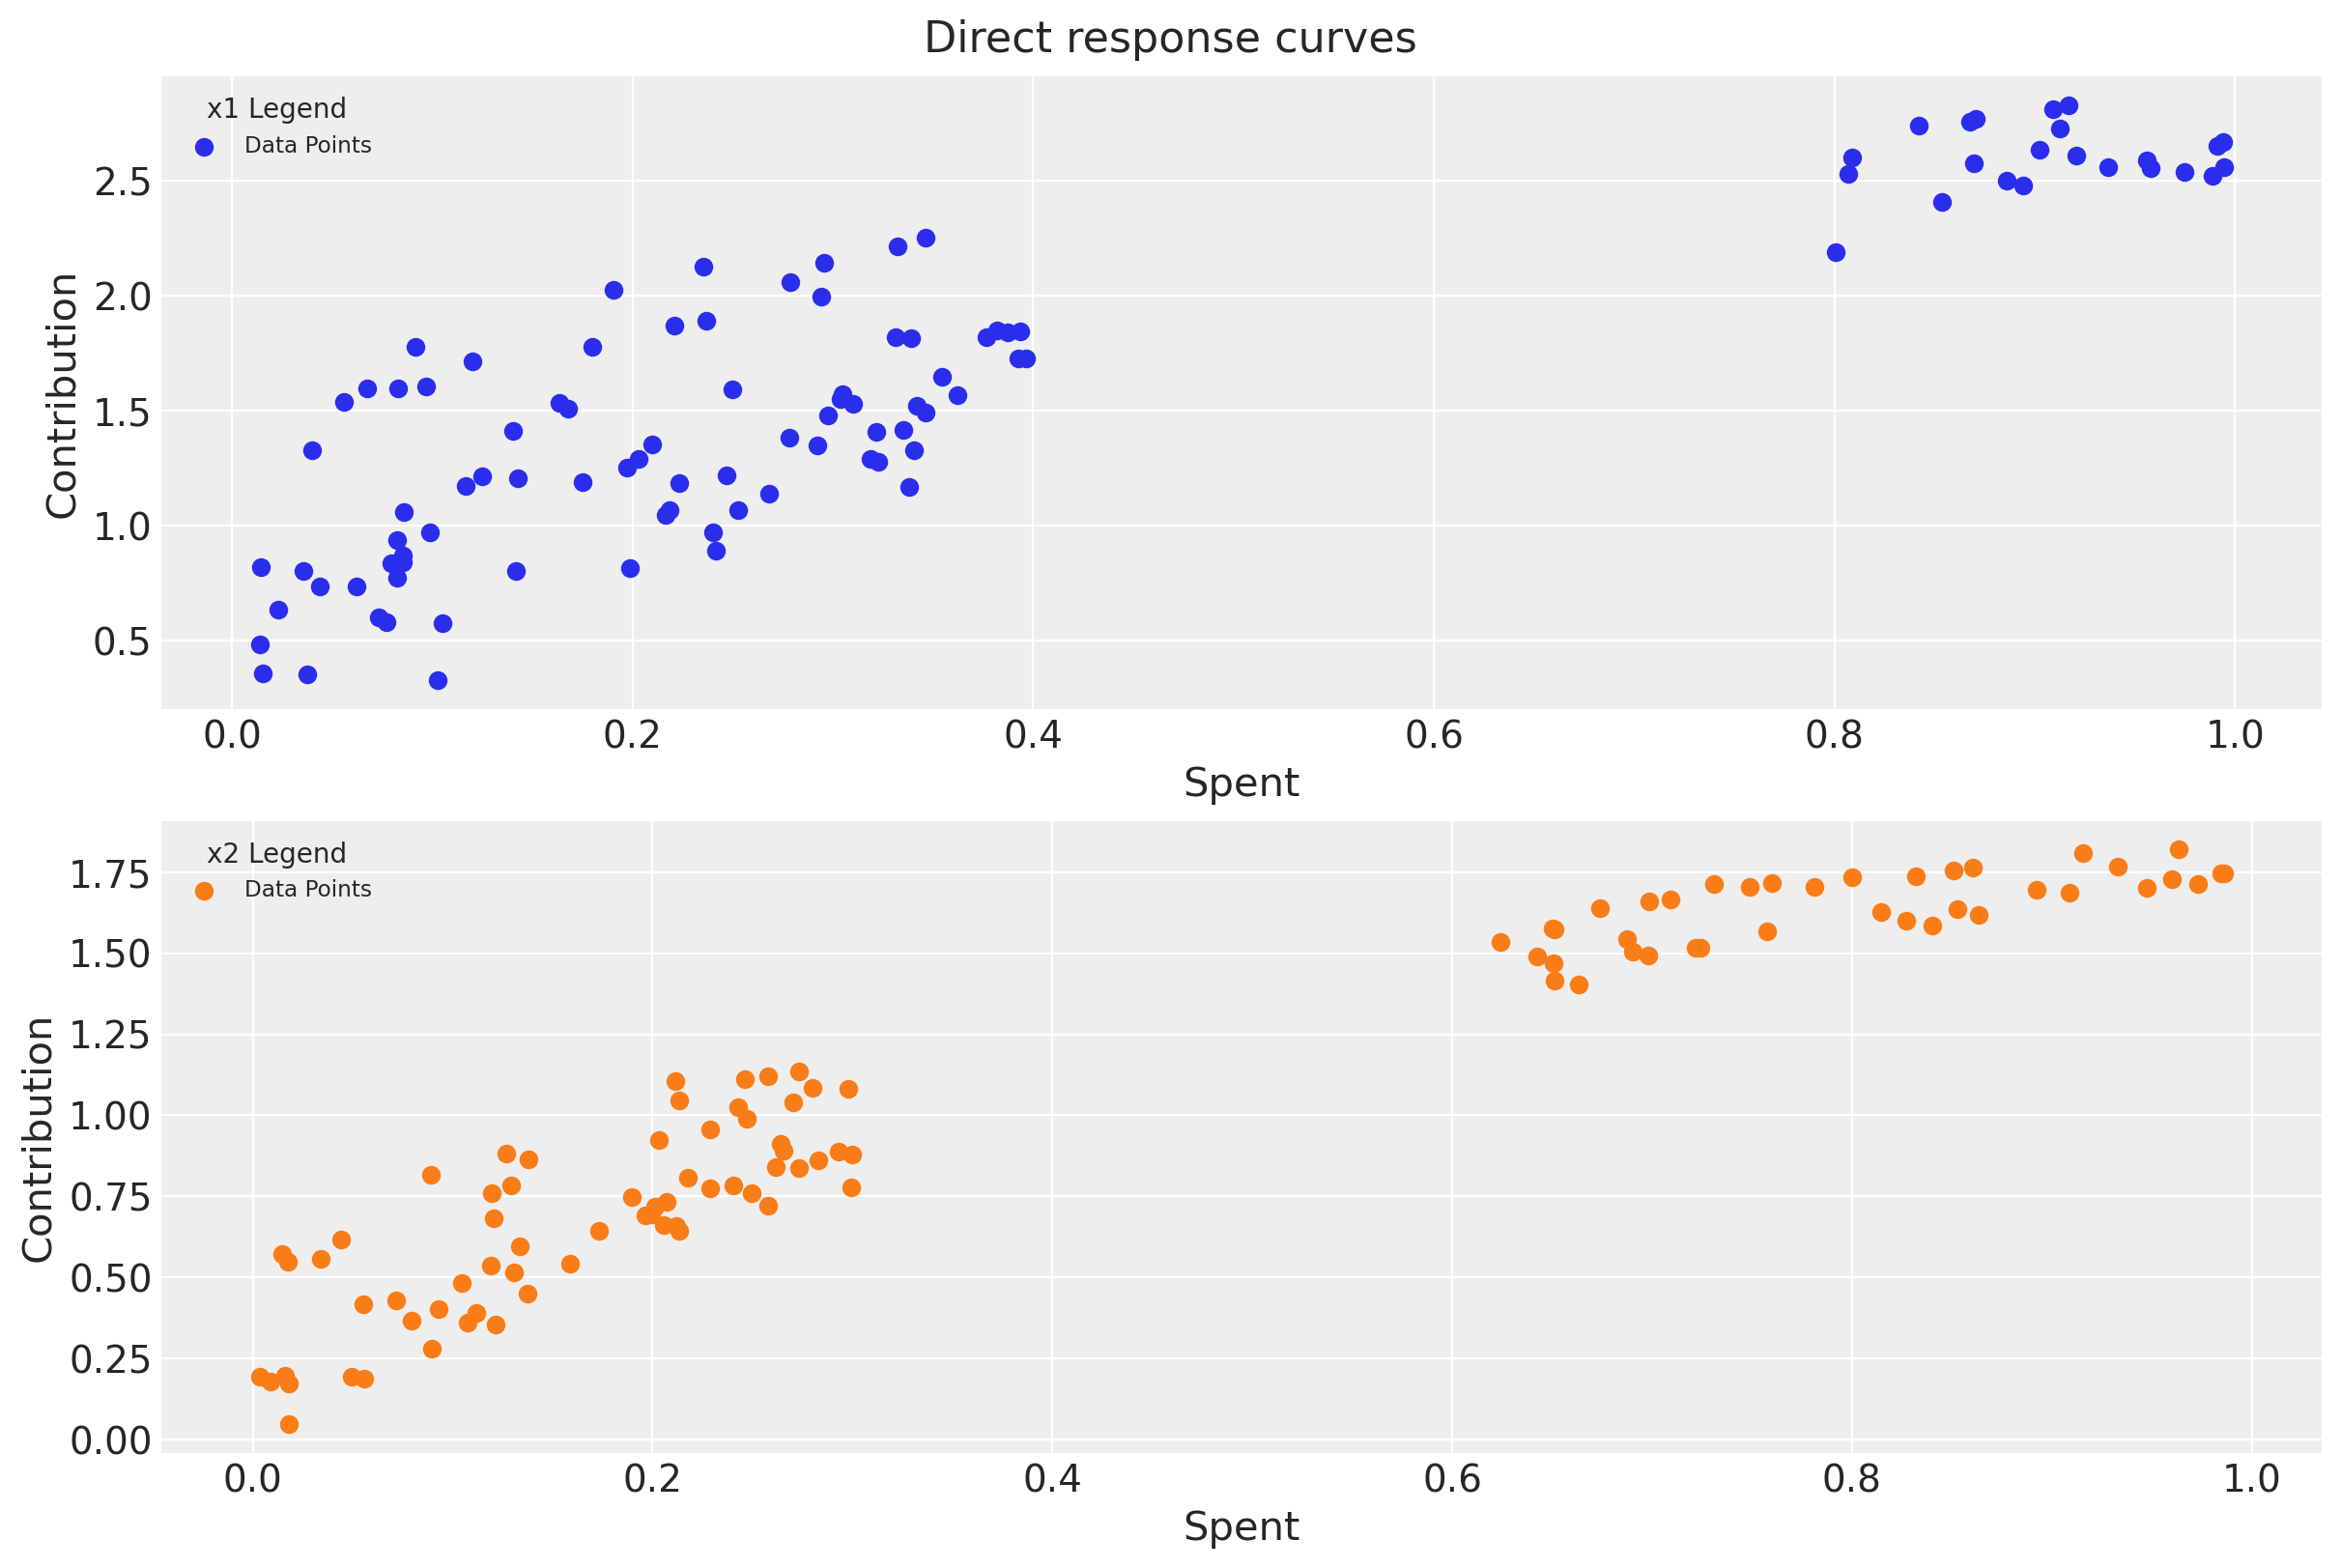

In [4]:
response_curve_fig = mmm.plot_direct_contribution_curves()


# How do we distribute our budget?
* We're going to use 2 methods to distribute our budget.
  -  Sigmoid method
  - Michaelis-Menten Function
 
These 2 functions are going to solve our problem

# Which function should I use?

* To determine that we should use plot_direct_contribution_curves with show_fit=True parameter.

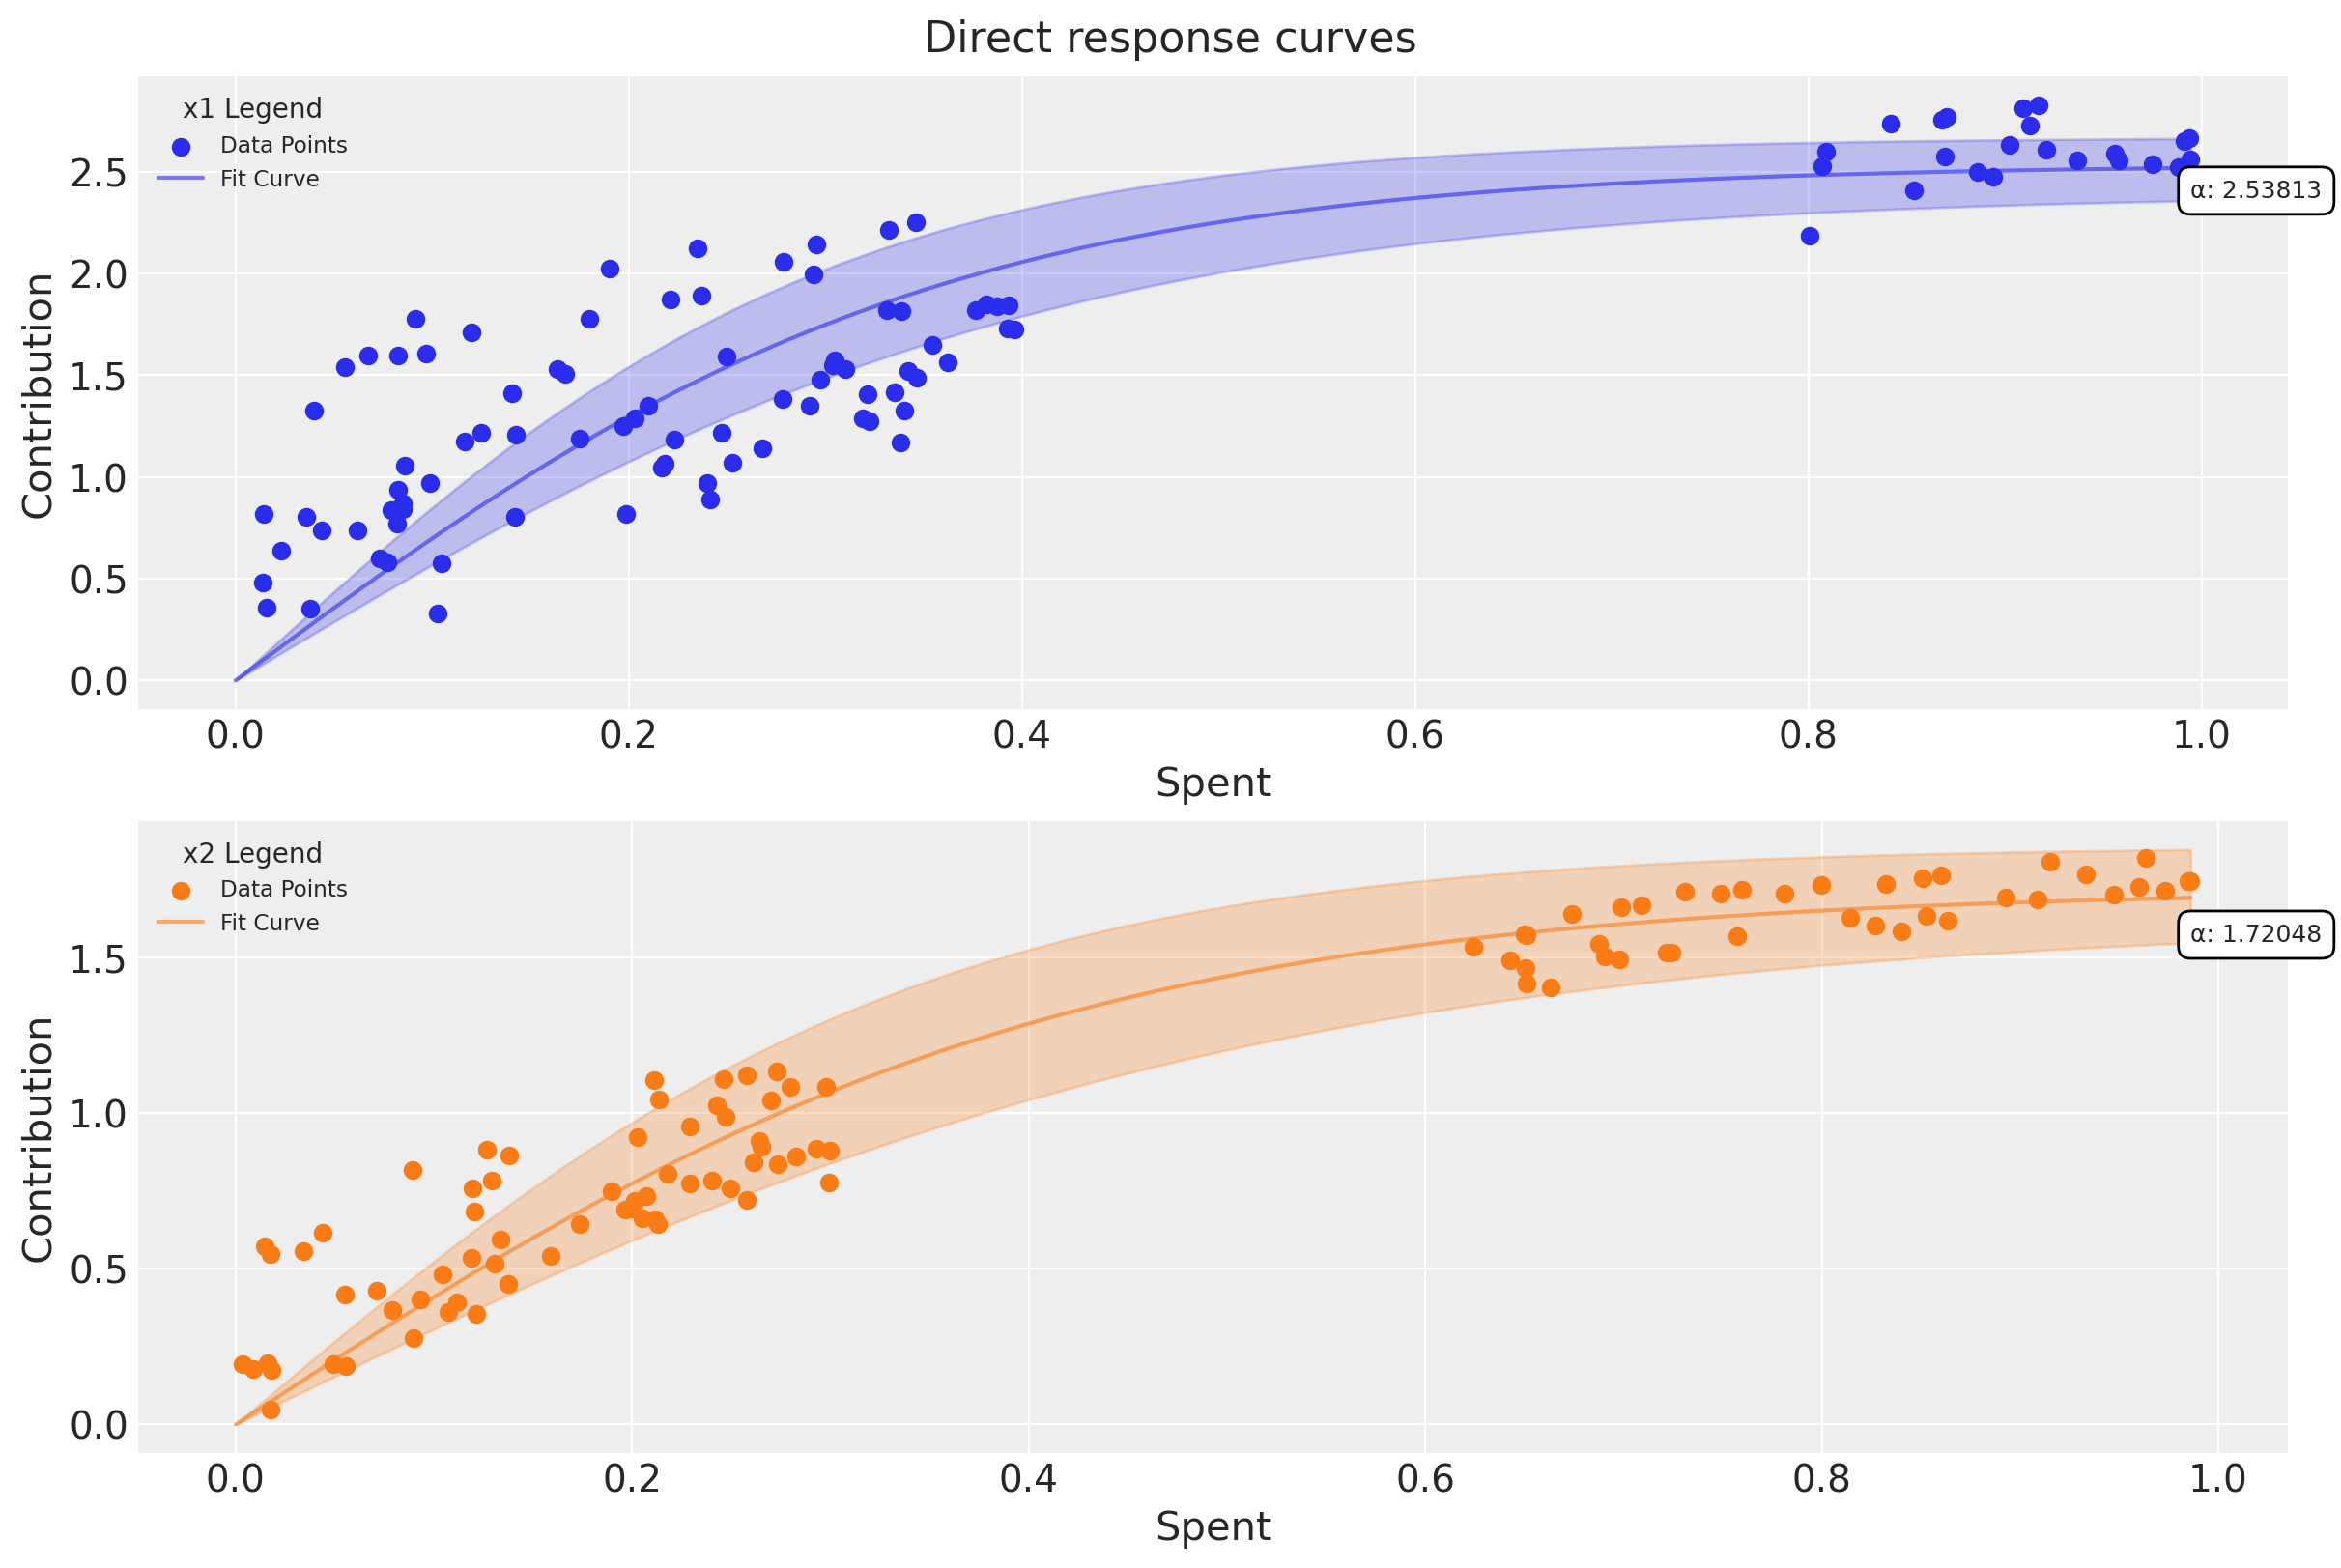

In [5]:
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(show_fit=True)


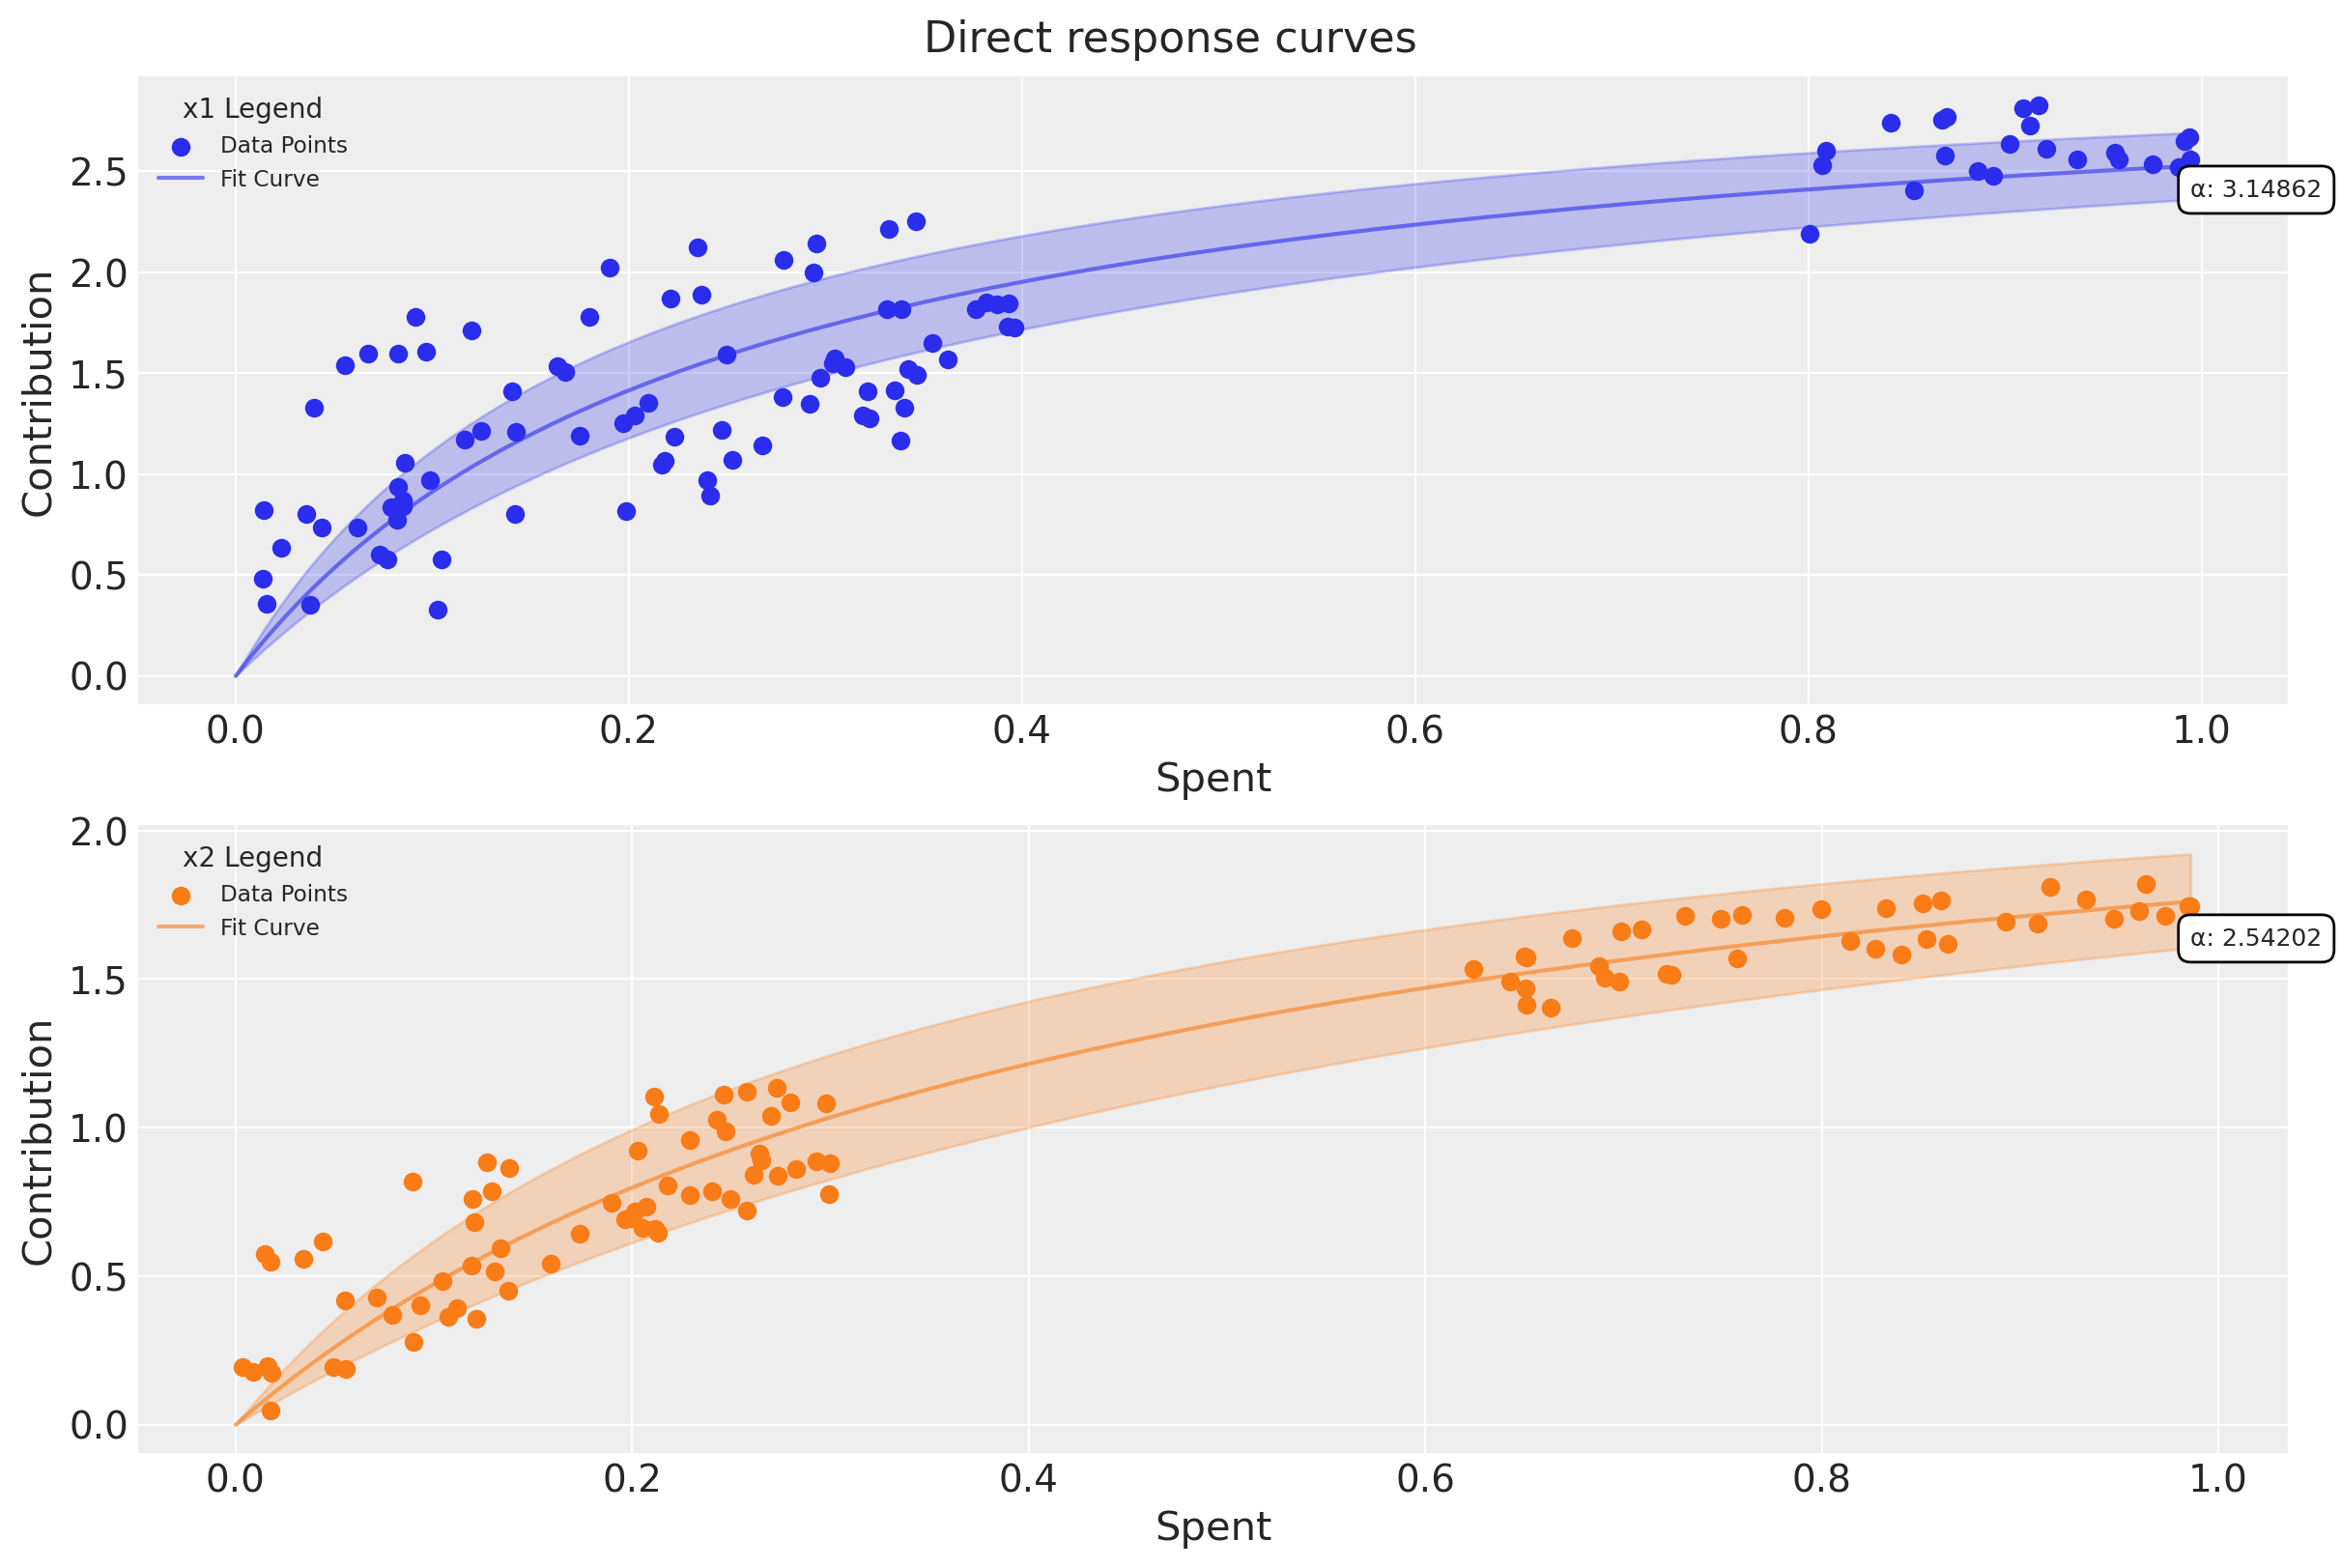

In [6]:
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(
show_fit = True, method='michaelis-menten'
)

In [7]:
sigmoid_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='sigmoid')

menten_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='michaelis-menten')

# What We Get

In [8]:
sigmoid_params, menten_params

({'x1': array([2.53812951, 5.64127966]),
  'x2': array([1.72048303, 4.84485564])},
 {'x1': array([3.14862238, 0.24520075]),
  'x2': array([2.54202266, 0.43725038])})

# How do we use those parameters ?

# Maximizing Contribution

In [9]:
total_budget = 5 #Imagine is 5K or 5M
#Define your channels
channels = ['x1','x2']
#The initial split per channel
budget_per_channel = total_budget / len(channels)
#Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}
#bounds for each channel
min_budget, max_budget = 1,5
budget_bounds = {channel: [min_budget, max_budget] for channel in channels}

In [10]:
result_sigmoid = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid', #define saturation function
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = budget_bounds
)

result_sigmoid

,estimated_contribution,optimal_budget
x1,2.538126,2.499664
x2,1.720464,2.500336
total,4.258590,5.000000


In [11]:
result_menten = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'michaelis-menten',
    total_budget = total_budget,
    parameters = menten_params,
    budget_bounds = budget_bounds
)
result_menten

,estimated_contribution,optimal_budget
x1,2.849685,2.337427
x2,2.183454,2.662573
total,5.033138,5.000000


In [12]:
from pymc_marketing.mmm.budget_optimizer import calculate_expected_contribution

#Use the function `calculate_expected_contribution` to estimate
#the contribution of your initial budget based on the curve parameters.
initial_contribution = calculate_expected_contribution(
    method='sigmoid',
    parameters = sigmoid_params,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict
}

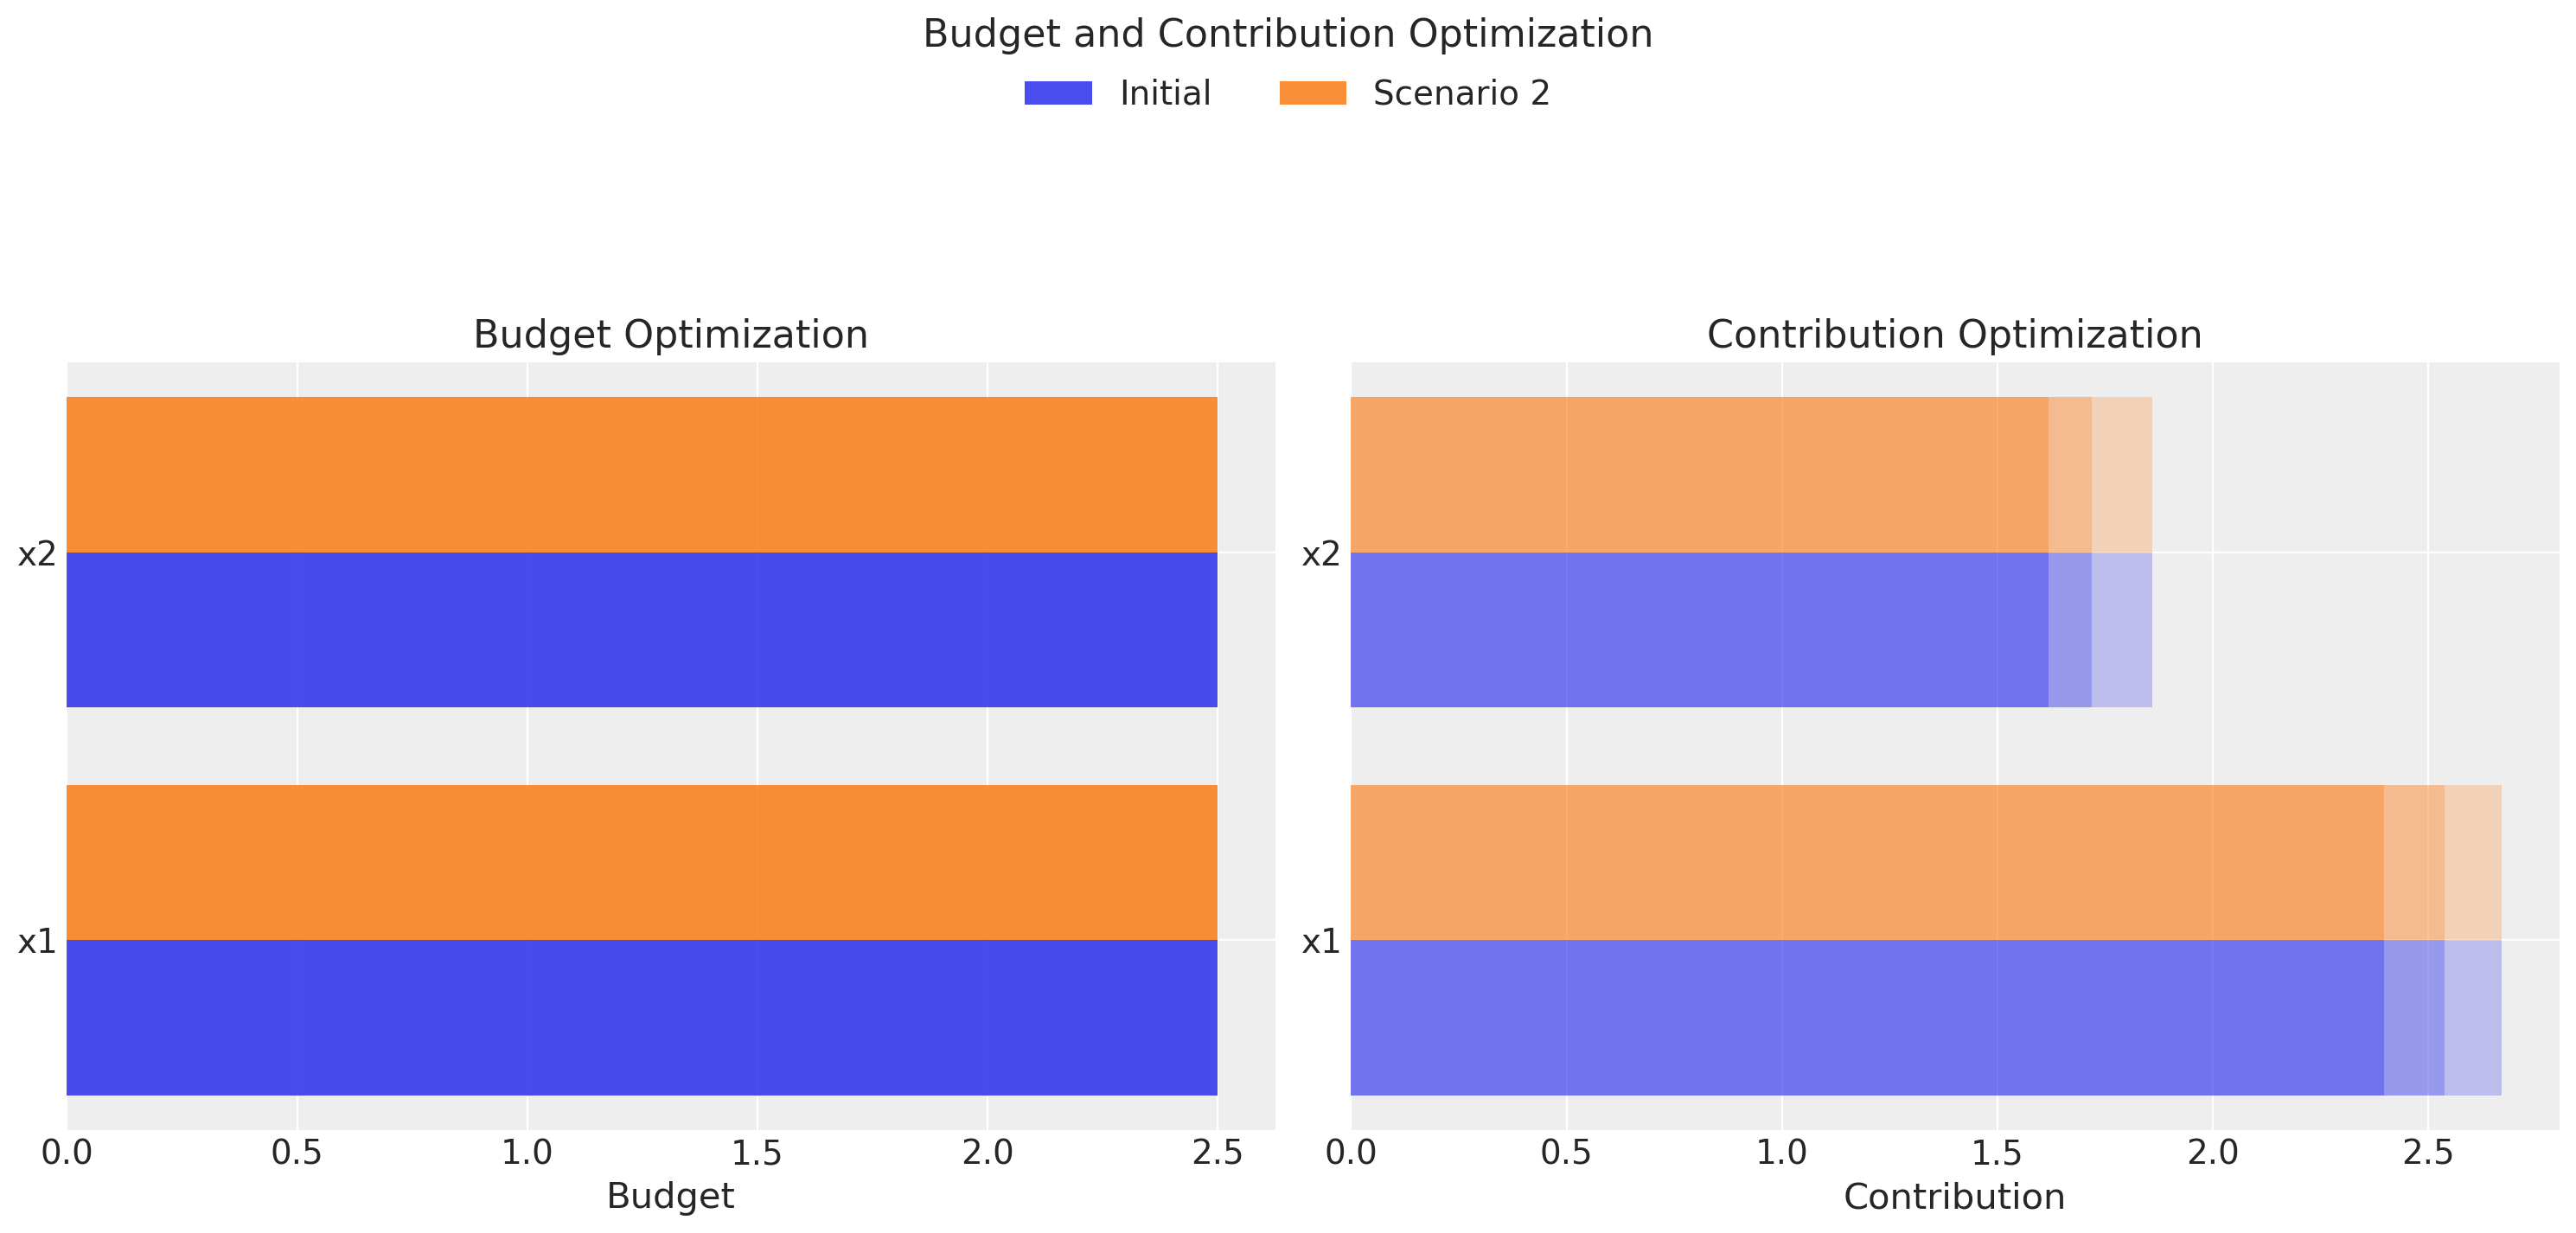

In [13]:
#Use the function `compare_budget_scenearios` to validate
#The estimated contribution from one scenario agains the other
figure_ = mmm.plot_budget_scenearios(base_data=initial_scenario, method='sigmoid', scenarios_data=[result_sigmoid])

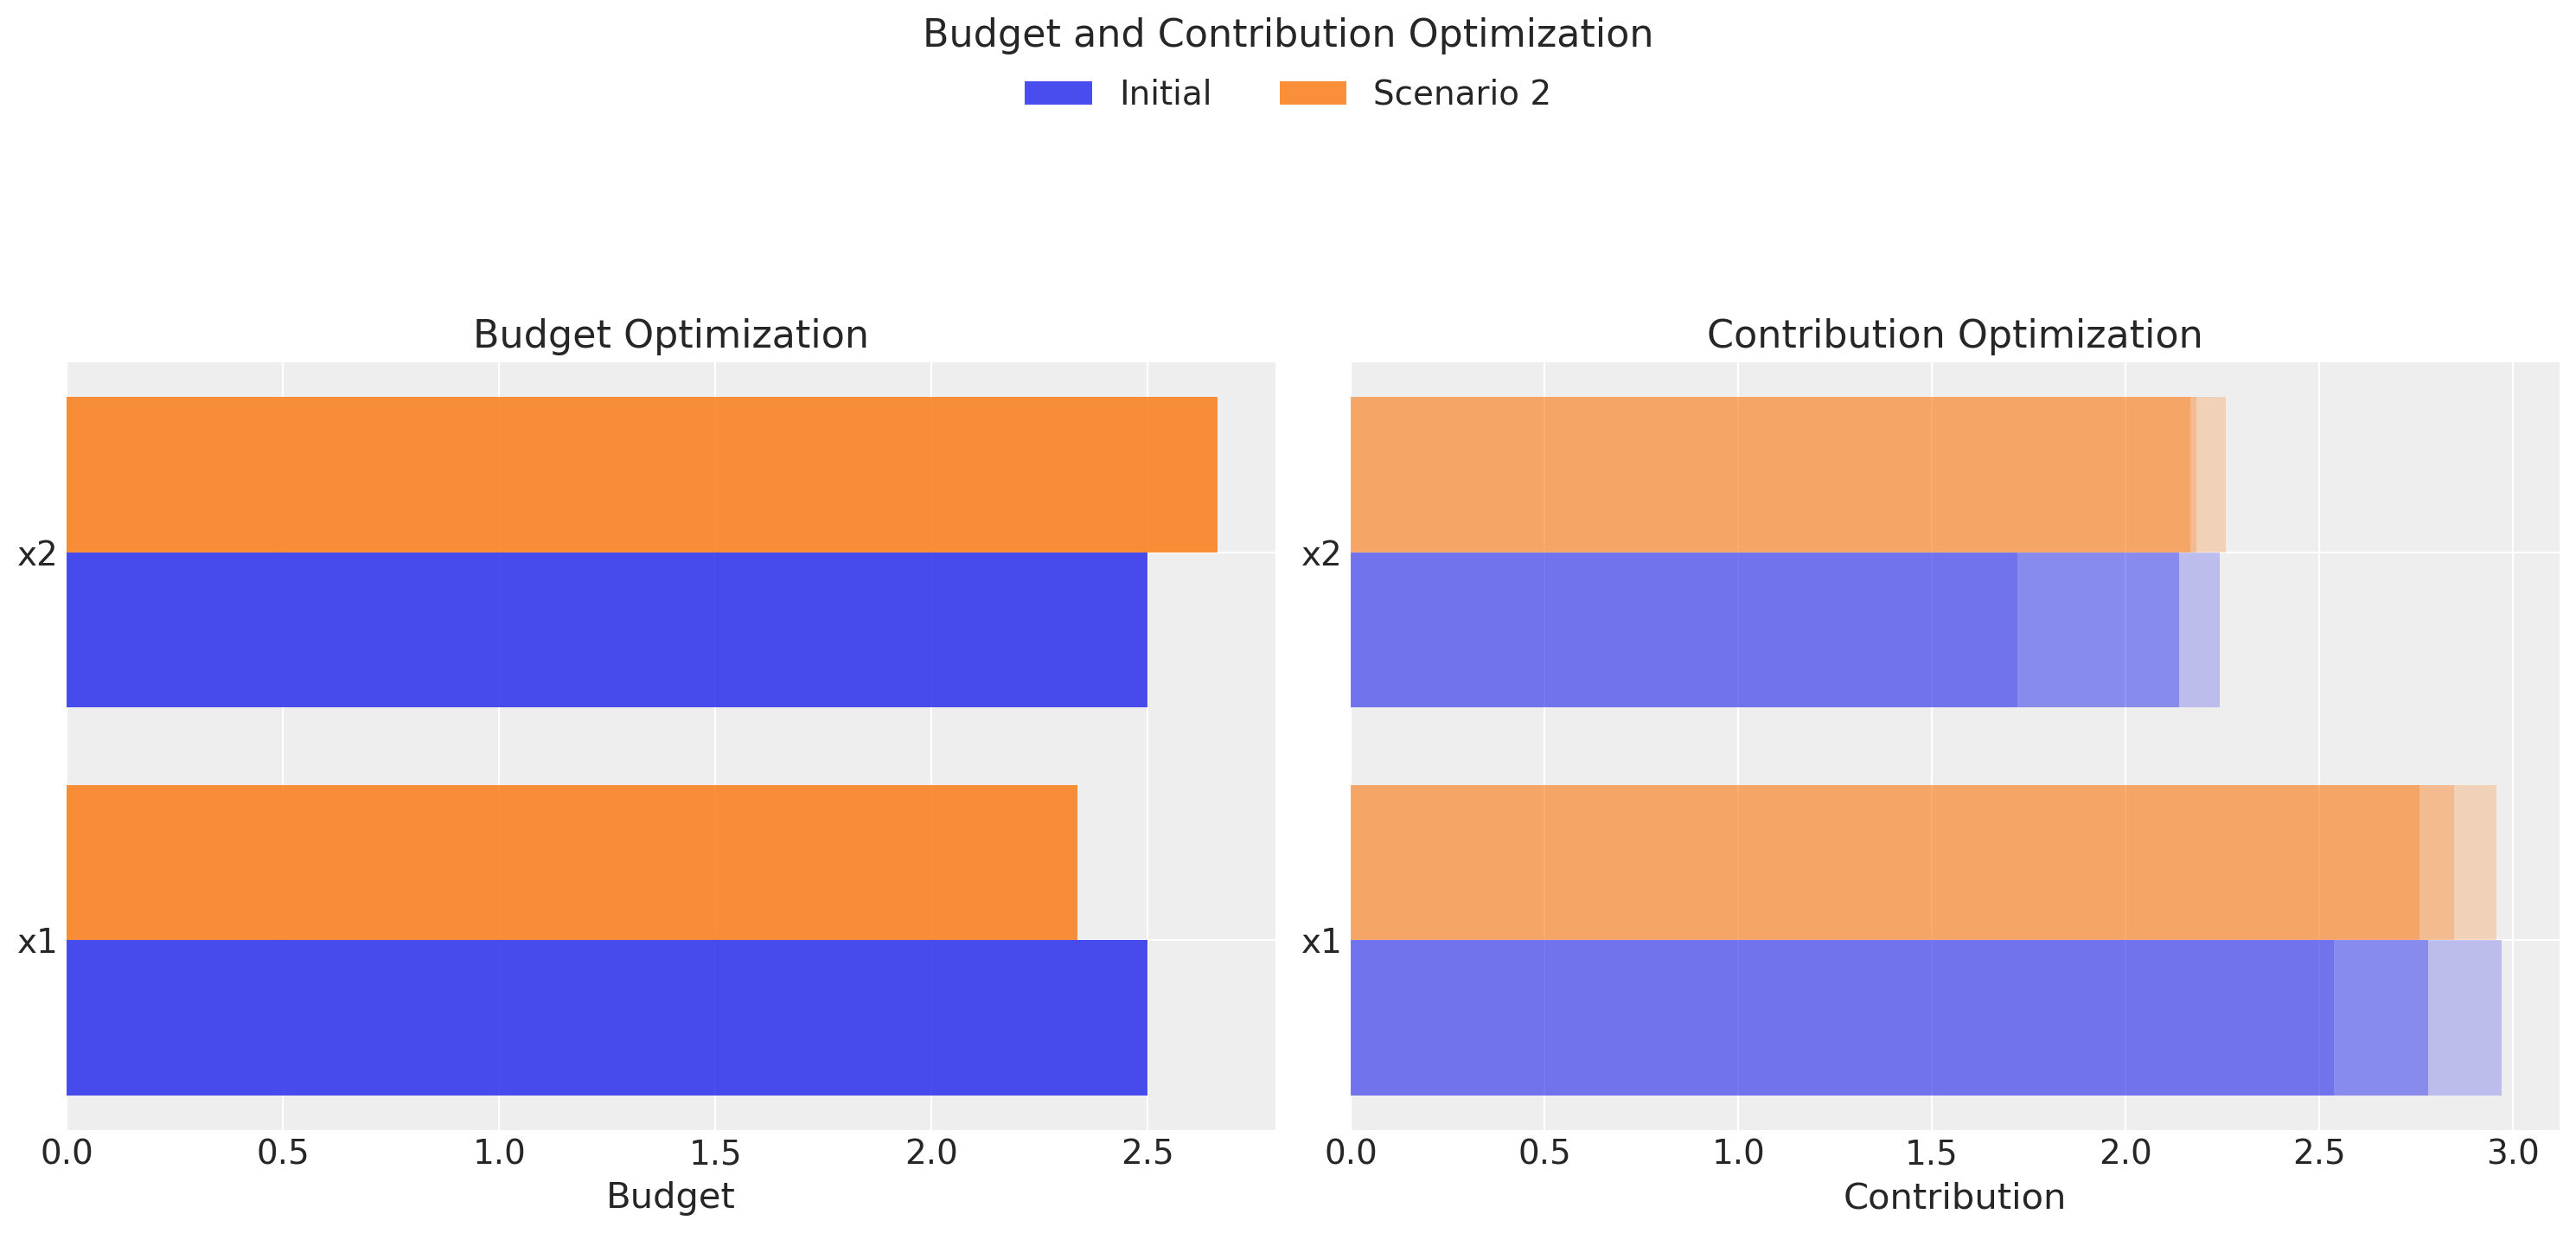

In [14]:
#Use the function `compare_budget_scenearios` to validate
#The estimated contribution from one scenario agains the other
figure_2 = mmm.plot_budget_scenearios(base_data=initial_scenario, method='michaelis-menten', scenarios_data=[result_menten])



# Creating Budget Scenarios

In [15]:
#Initialize two variables to save the results and base conditions for each scenario.
scenarios_result = []
scenarios_base = []

for scenario in np.array([0.6, 0.8, 1.2, 1.8]):
  scenarios_result.append(
    mmm.optimize_channel_budget_for_maximum_contribution(
        method = 'sigmoid', #define saturation function
        total_budget = total_budget * scenario,
        parameters = sigmoid_params,
        budget_bounds = {channel: [1, total_budget * scenario] for channel in channels}
    ).to_dict()
  )

  scenarios_base.append(
    {'initial_contribution': calculate_expected_contribution(
      method='sigmoid', #define saturation function
      parameters = sigmoid_params,
      budget = {channel: total_budget * scenario / len(channels) for channel in channels}
      ),

      'initial_budget': {channel: total_budget * scenario / len(channels) for channel in channels}
    }
  )

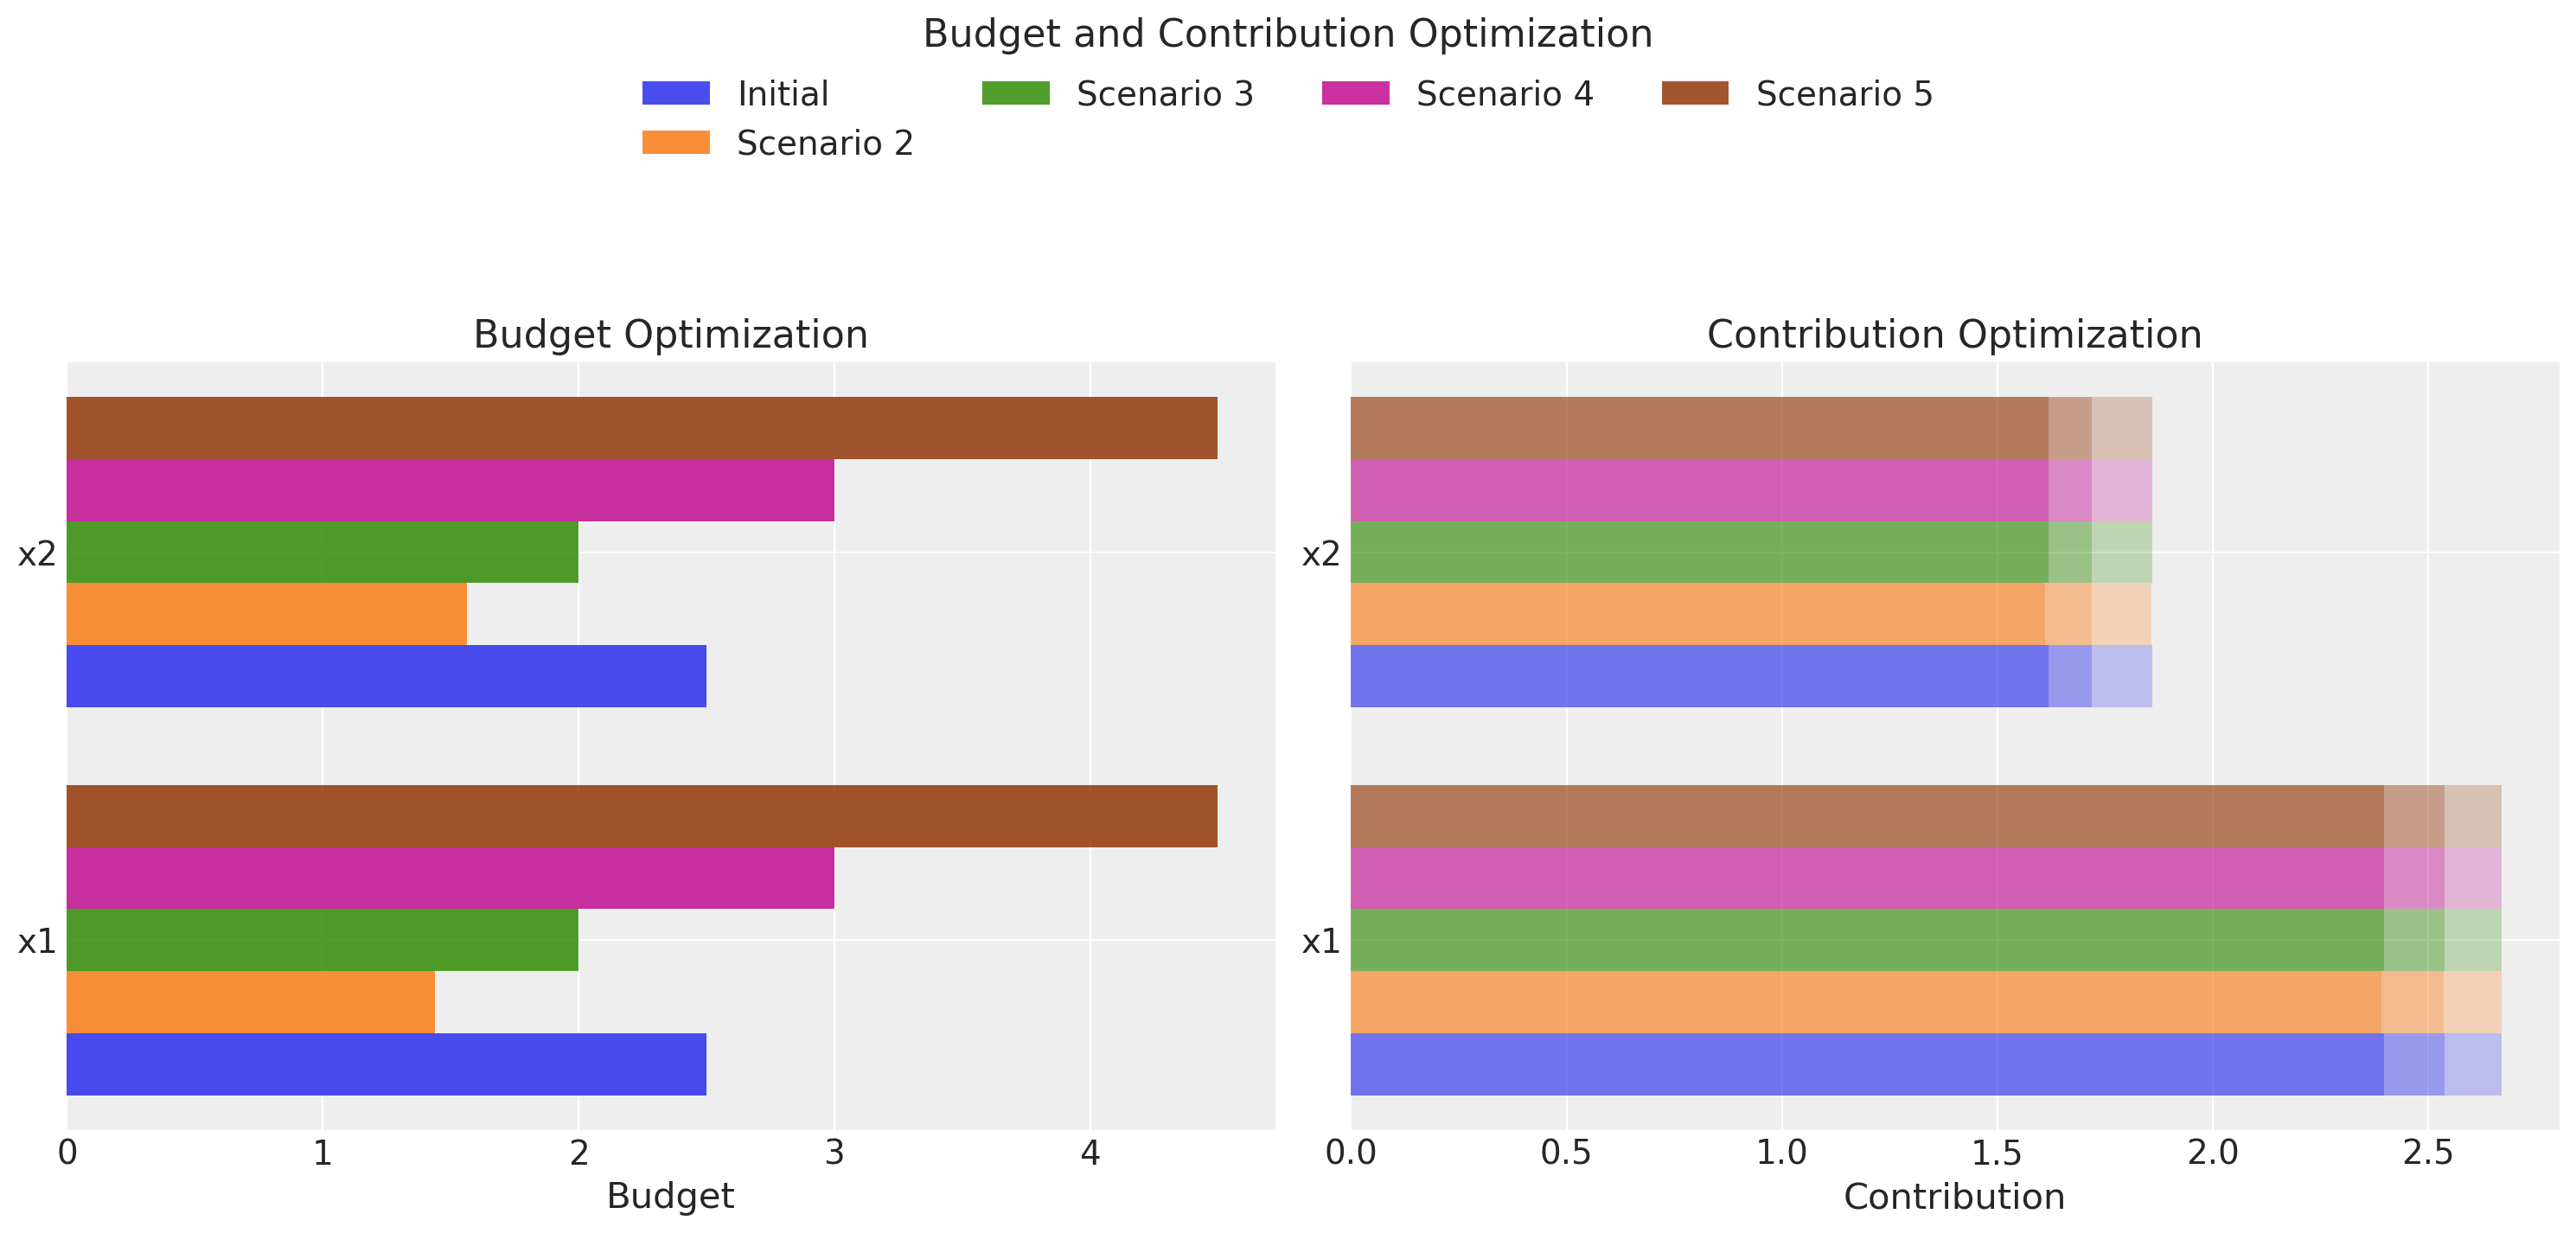

In [16]:
#Use the function `compare_budget_scenearios` to validate
#The estimated contribution from one scenario agains the other
_figure = mmm.plot_budget_scenearios(base_data=initial_scenario, method='sigmoid', scenarios_data=scenarios_result)

The graph indicates that boosting the budget beyond the levels of scenario number 3 induces extremely marginal changes in the potential outcome. Therefore, one can use the budget detailed in scenario three as a cap for our budget.

However, is this the best method to invest our resources? So far, we have considered general constraints for each channel. However, since our curve saturates and beyond a specific point, it does not significantly elevate its contribution. Wouldn’t it be crucial to incorporate these limitations?

# Adding Business or Channel Constraints

In [17]:
platform_base_optimization = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid',
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = {'x1':[0,1.5],
                     'x2':[0,1.5]
                     }
)

platform_base_optimization

,estimated_contribution,optimal_budget
x1,2.537057,1.5
x2,1.718083,1.5
total,4.255140,3.0


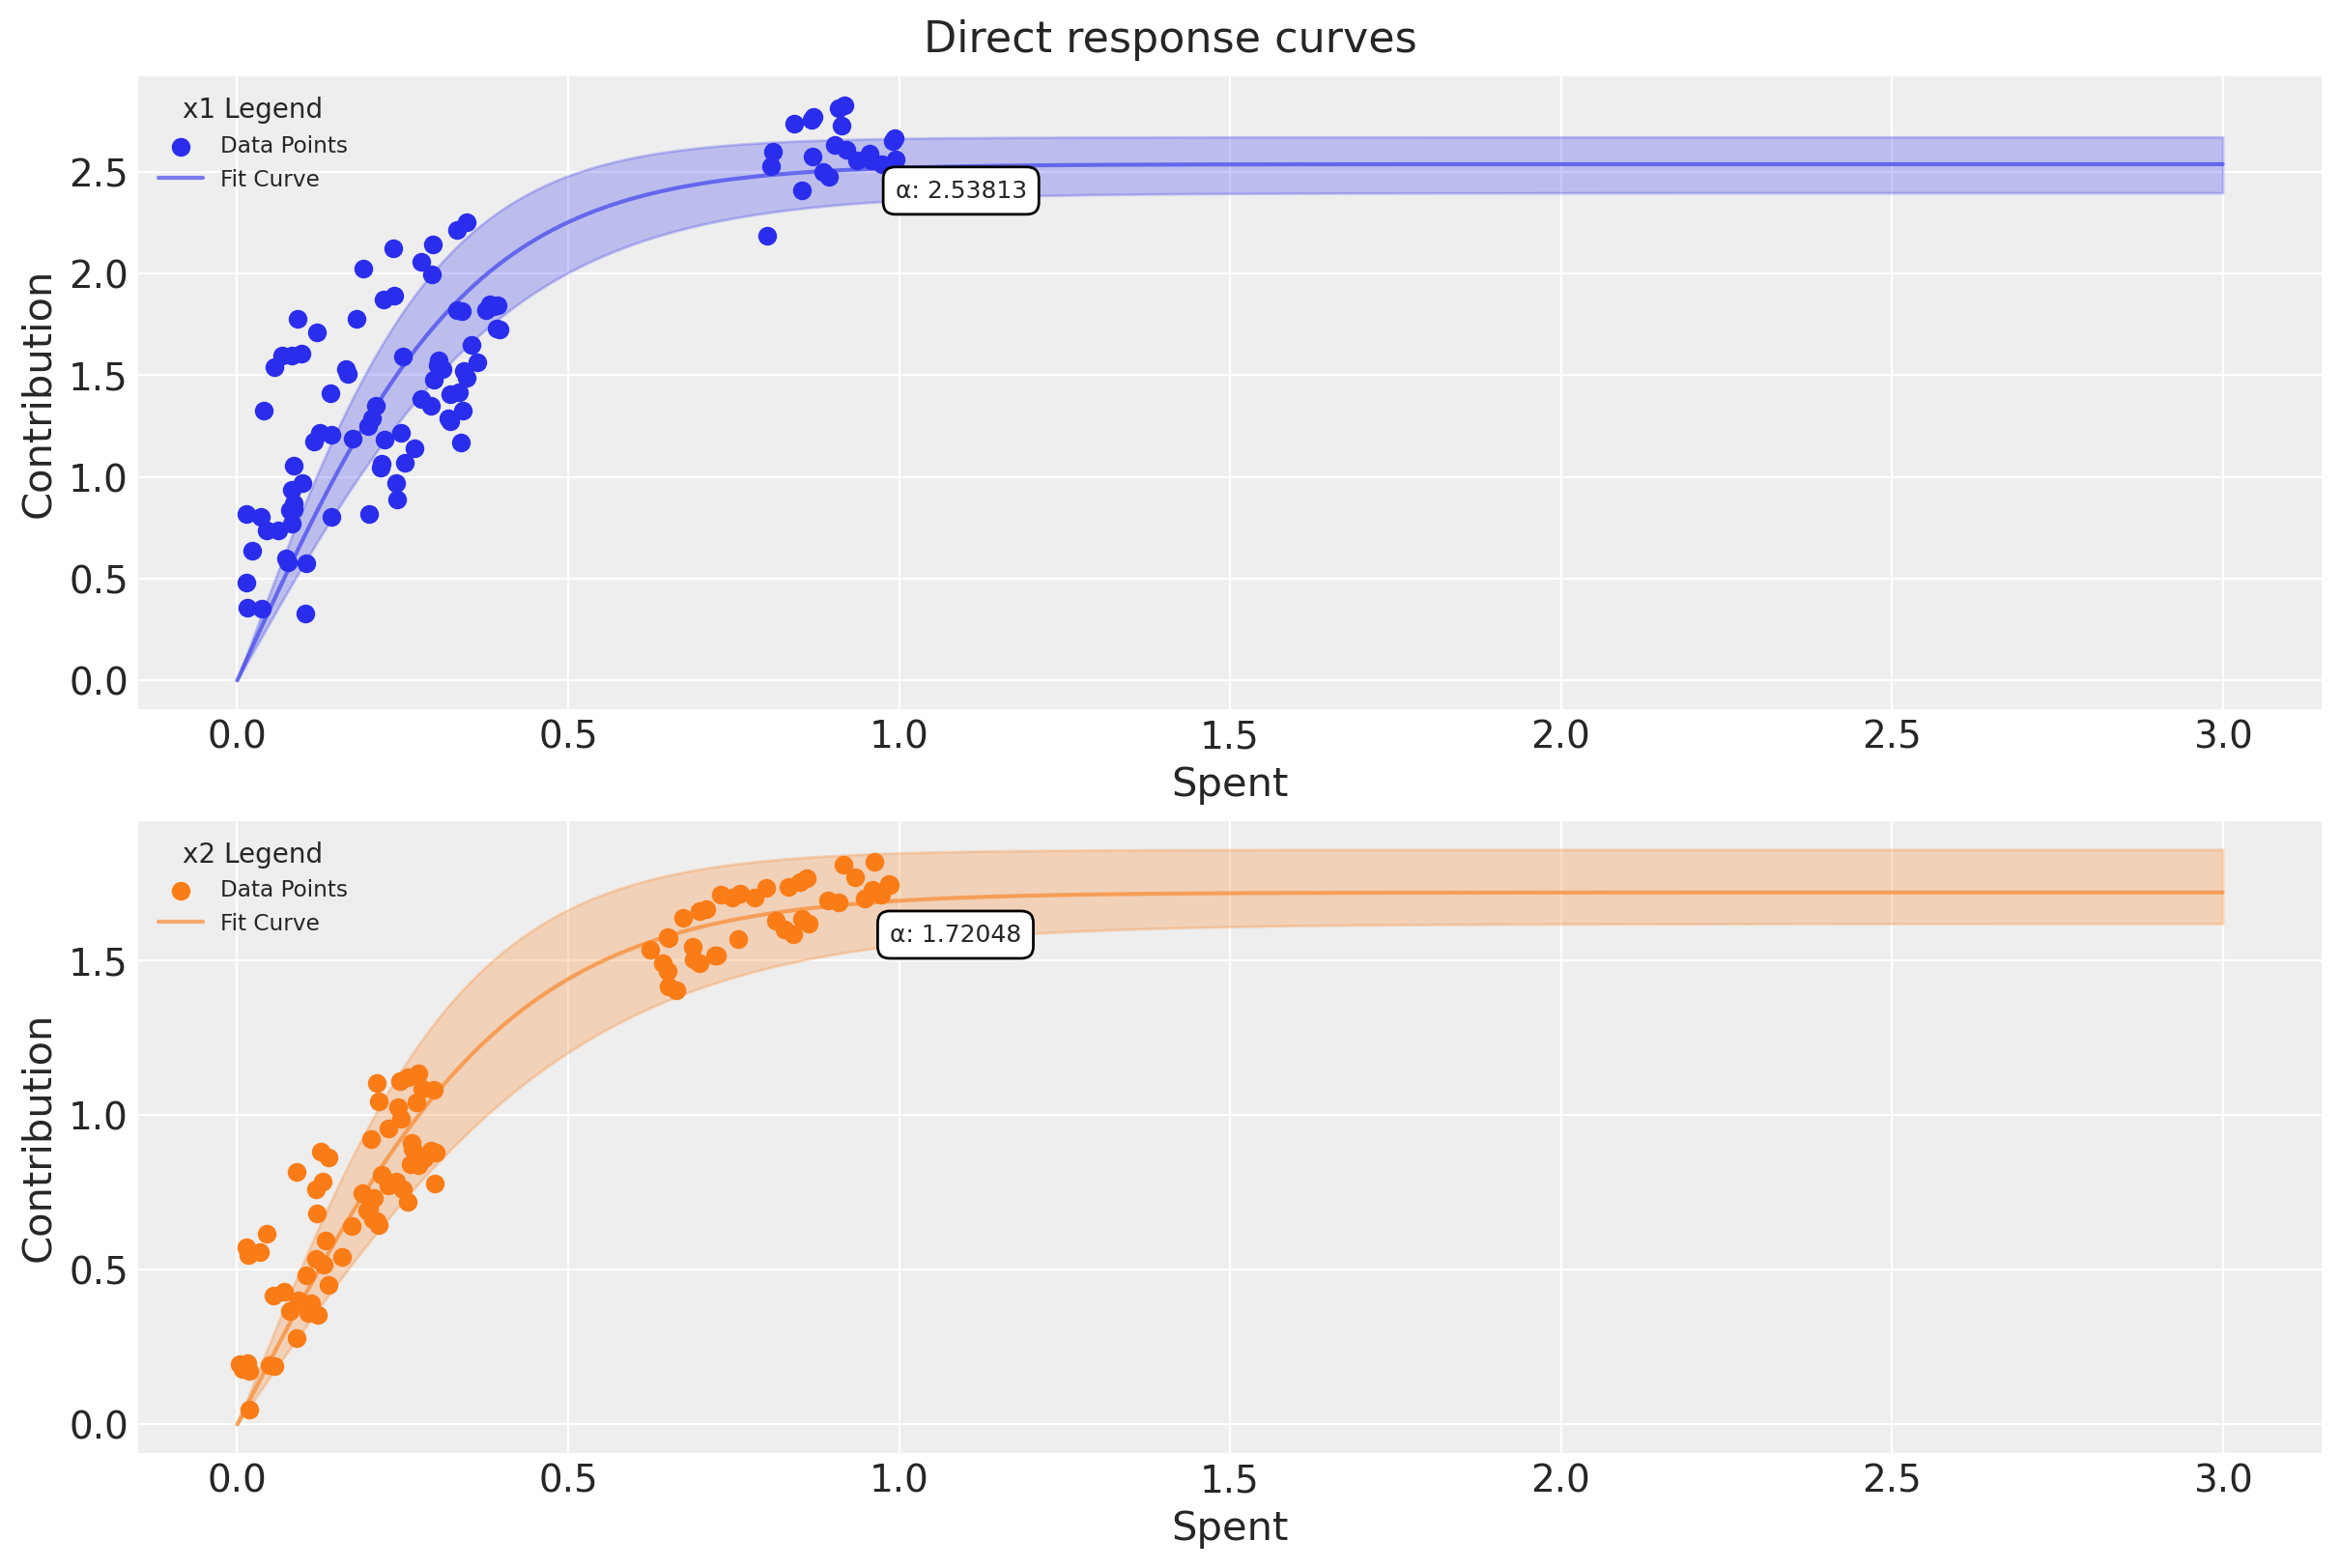

In [18]:
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(
show_fit = True, method='sigmoid', xlim_max=3
)

In [19]:
platform_base_optimization = mmm.optimize_channel_budget_for_maximum_contribution(
    method = 'sigmoid',
    total_budget = total_budget,
    parameters = sigmoid_params,
    budget_bounds = {'x1':[0,1.2],
                     'x2':[0,1.5]
                     }
)

platform_base_optimization

,estimated_contribution,optimal_budget
x1,2.532307,1.2
x2,1.718083,1.5
total,4.250390,2.7


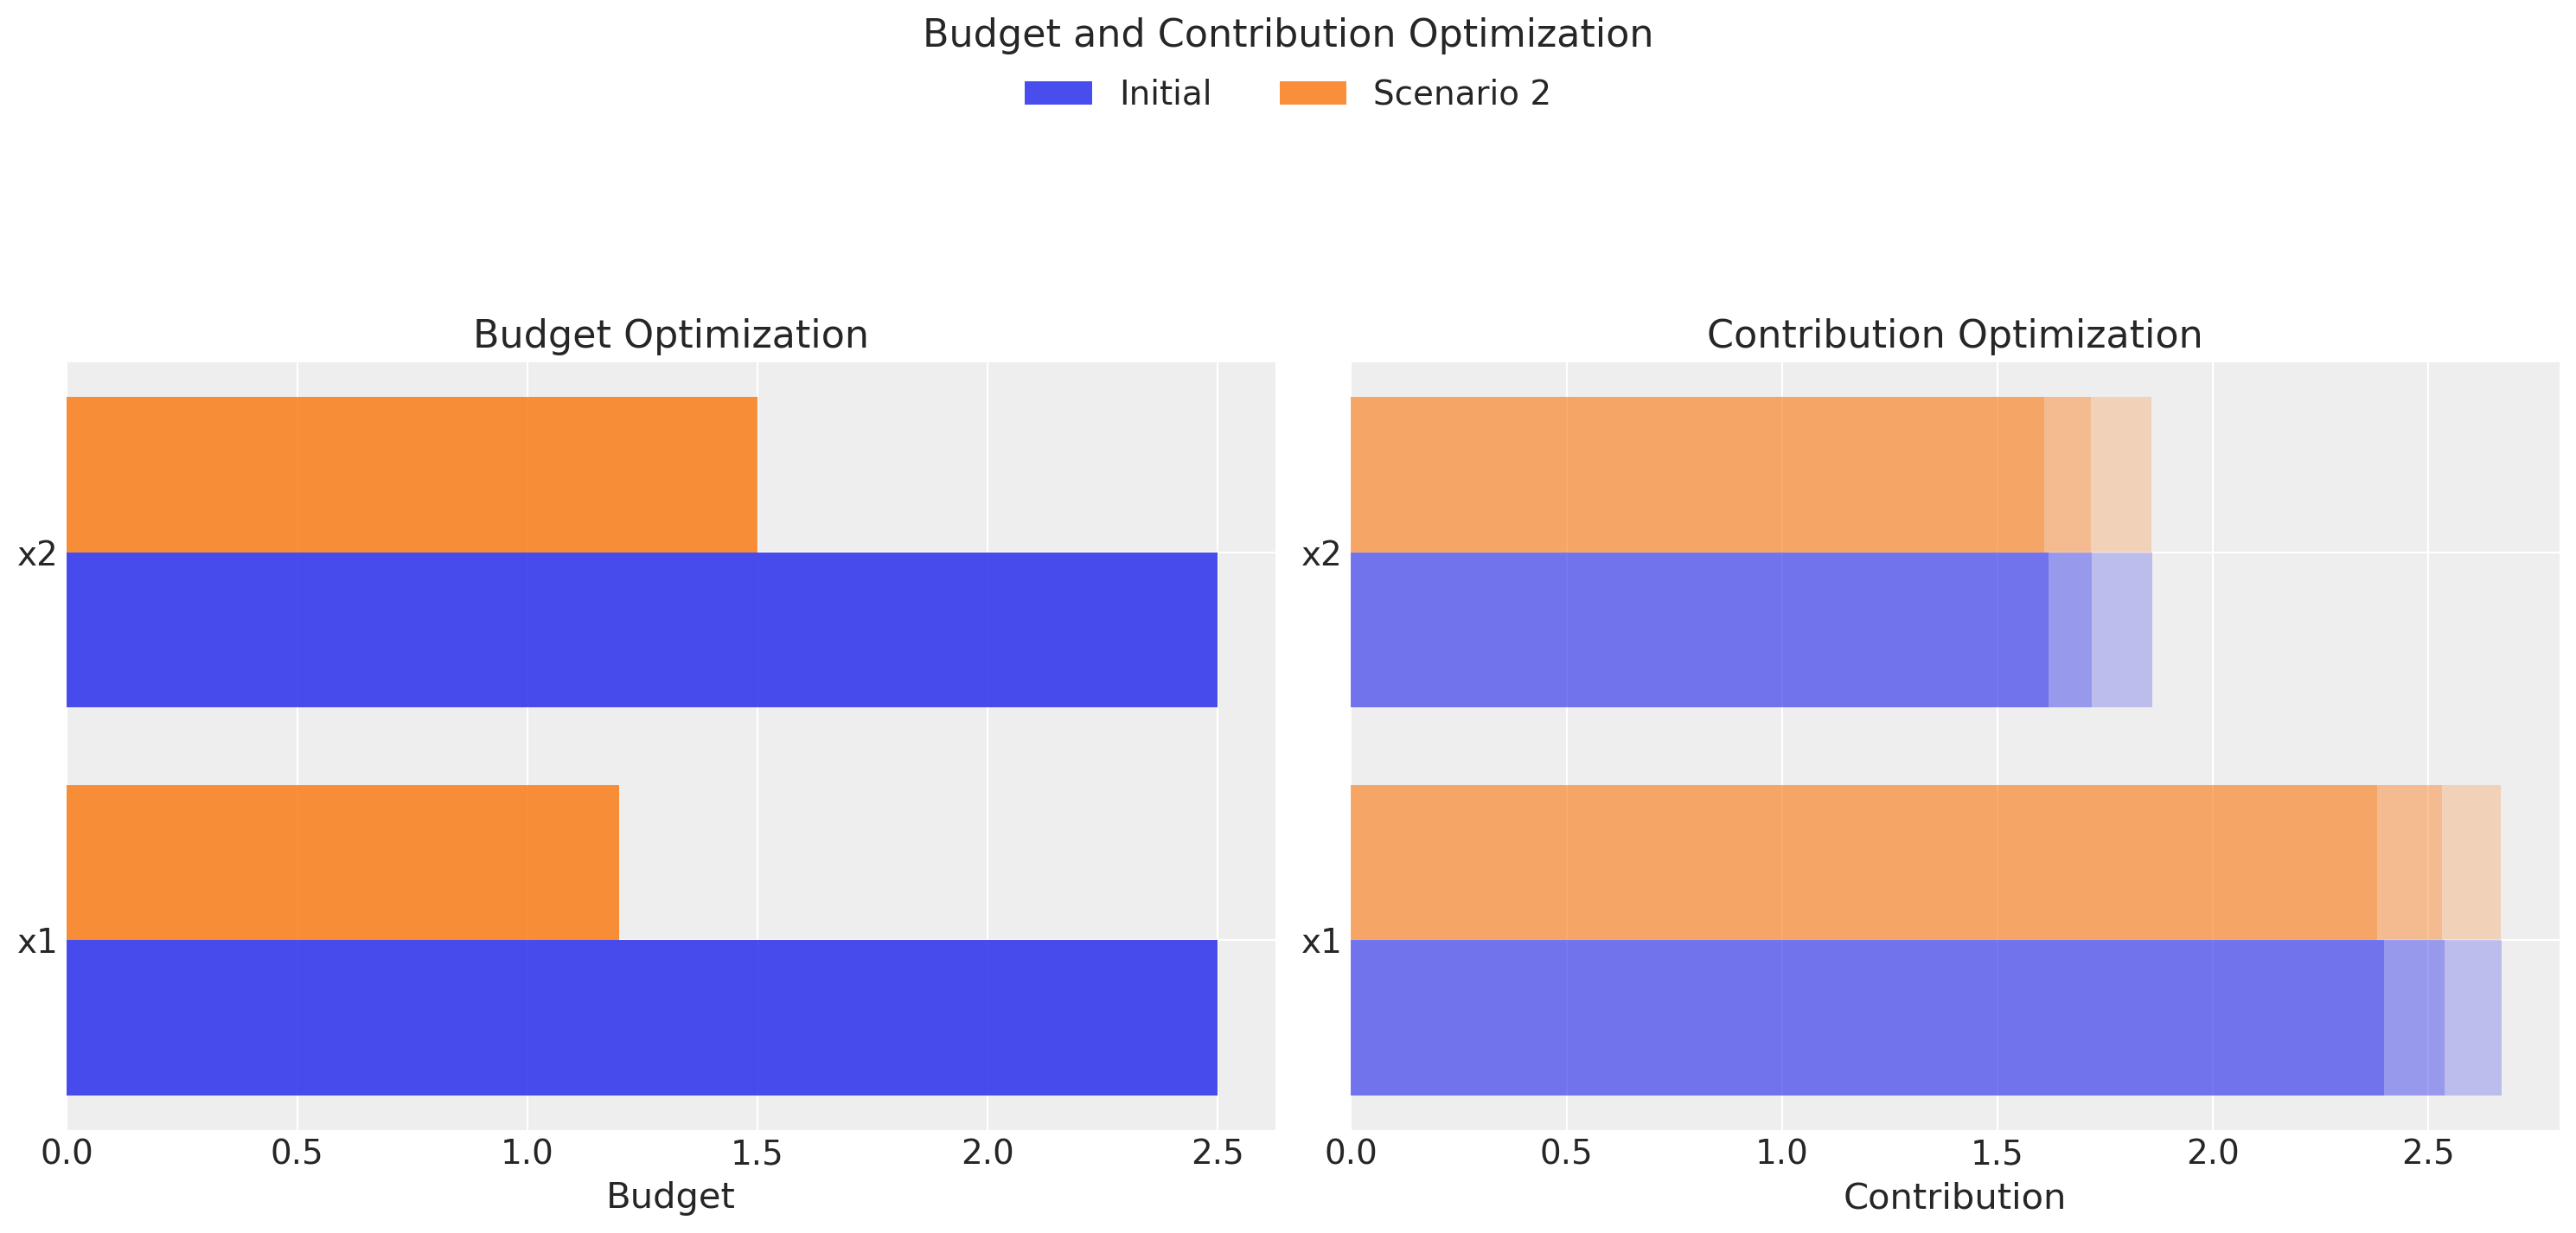

In [20]:
_figure = mmm.plot_budget_scenearios(base_data=initial_scenario, method='sigmoid', scenarios_data=[platform_base_optimization])

Now, the result is considerably more explicit. Using nearly half of the budget with the current distribution configuration could yield the same number of outcomes as our initial setup, which dispersed the budget evenly across all channels.